In [1]:
import pandas as pd 
from thefuzz import fuzz

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/yl3808/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yl3808/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Preprocess function
def preprocess(text):
    if isinstance(text, float):
        return []  # Skip non-string entries
    tokens = word_tokenize(text.lower())  # Tokenization and lowercase
    tokens = [token for token in tokens if token.isalpha()]  # Remove punctuation
    tokens = [token for token in tokens if token not in stopwords.words('english')]  # Remove stopwords
    return tokens

In [6]:
tweets_df = pd.read_csv("cleaned_all_tweets.csv")

tweets_df['text'] = tweets_df['text'].fillna('')

# Define a function to check for fuzzy matches
def fuzzy_match(text, keywords, threshold=80):
    for keyword in keywords:
        if fuzz.partial_ratio(text.lower(), keyword.lower()) >= threshold:
            return True
    return False

# List of keywords to match, including correct spellings
keywords = ['accountable', 'accountability']

# Apply fuzzy matching to filter rows
filtered_data = tweets_df[tweets_df['text'].apply(fuzzy_match, args=(keywords,))]



/state/partition1/job-47260819/ipykernel_1156000/3495567487.py:1: DtypeWarning: Columns (0,1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets_df = pd.read_csv("cleaned_all_tweets.csv")


In [8]:
exact_data =  tweets_df[tweets_df['text'].str.contains('accountability', case=False, regex=True)]

In [11]:
filtered_data.to_csv('account_tweets.csv')

In [9]:
# Split data by year
exact_data['created_at'] = pd.to_datetime(exact_data['created_at'])
exact_data['year'] = exact_data['created_at'].dt.year

/state/partition1/job-47260819/ipykernel_1156000/4291793390.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exact_data['created_at'] = pd.to_datetime(exact_data['created_at'])
/state/partition1/job-47260819/ipykernel_1156000/4291793390.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exact_data['year'] = exact_data['created_at'].dt.year


In [12]:
# Train Word2Vec models and compute cosine similarity
years = exact_data['year'].unique()
word = "accountability"
similarities = {}

In [14]:
for year in years:
    # Preprocess tweets for the current year
    year_tweets = exact_data[exact_data['year'] == year]['text'].apply(preprocess)
    
    # Train Word2Vec model
    model = Word2Vec(year_tweets, vector_size=100, window=5, min_count=1, workers=4)
    
    # Compute cosine similarity
    similar_words = [word] + [w[0] for w in model.wv.most_similar(word)]
    similarities[year] = {w: cosine_similarity([model.wv[word], model.wv[w]])[0][1] for w in similar_words}


In [15]:
similarities.to_csv("similarities.csv")

AttributeError: 'dict' object has no attribute 'to_csv'

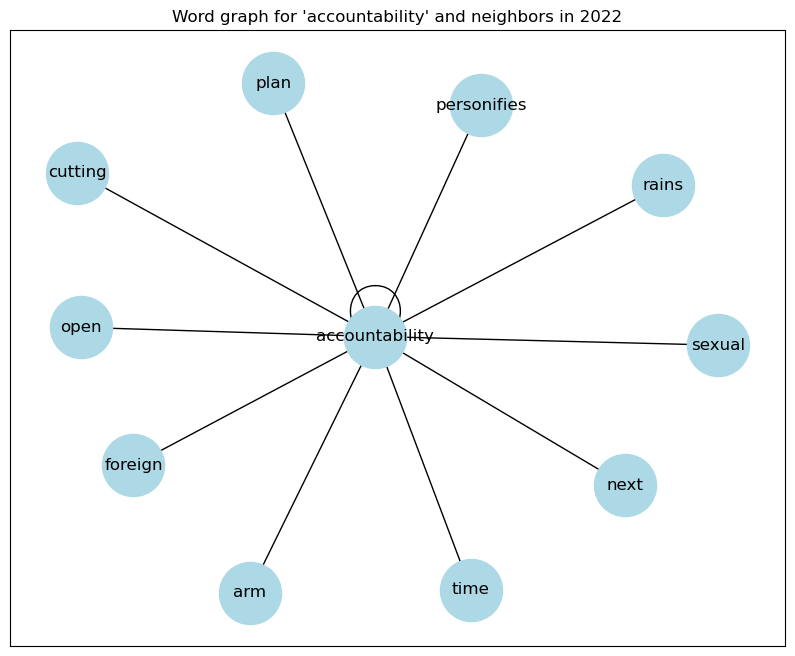

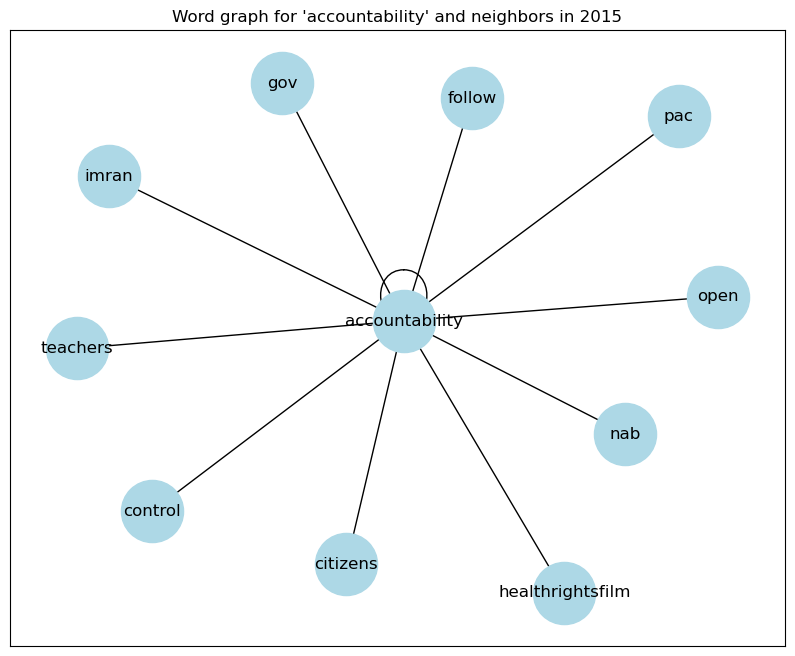

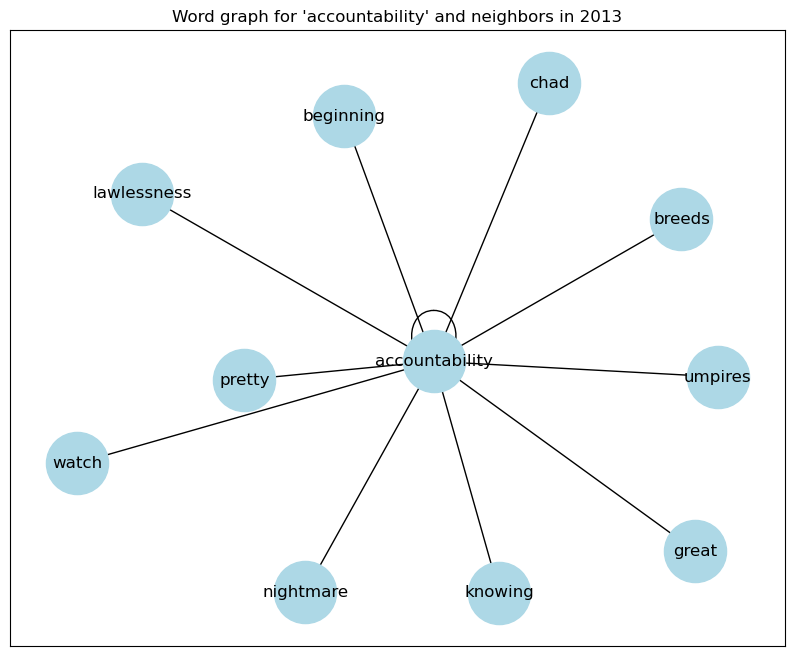

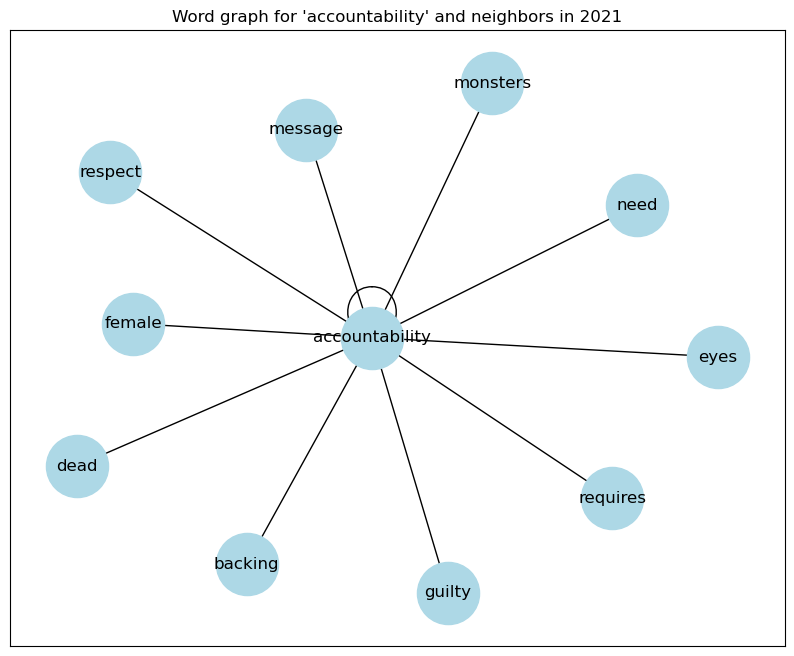

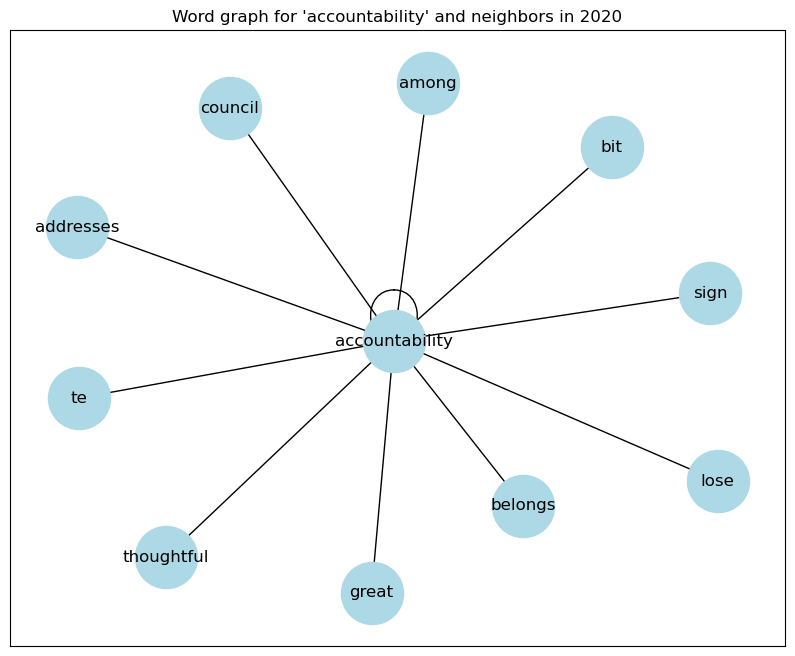

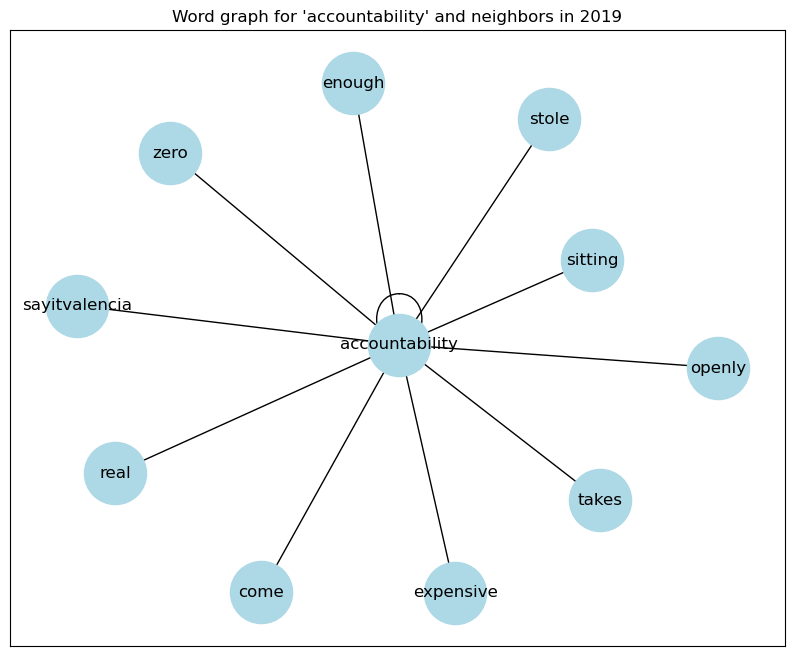

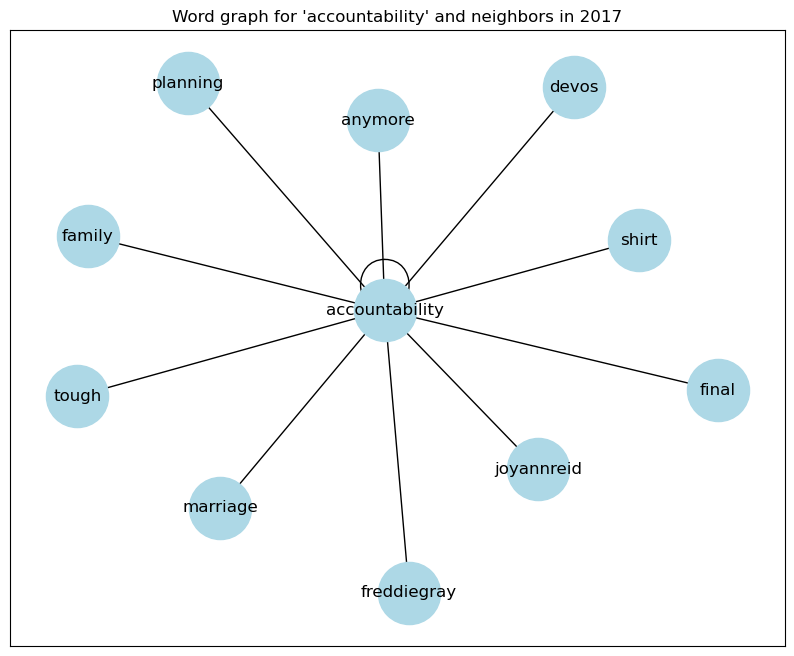

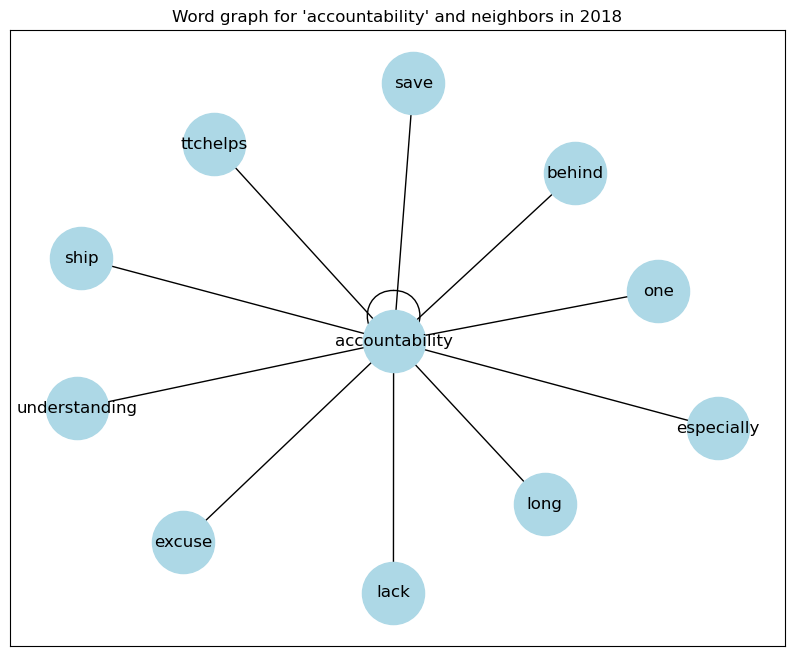

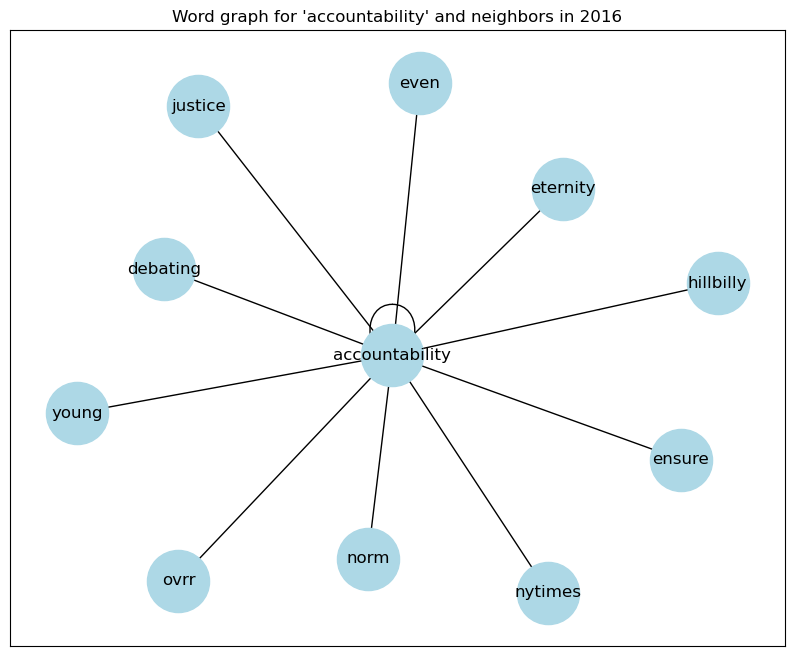

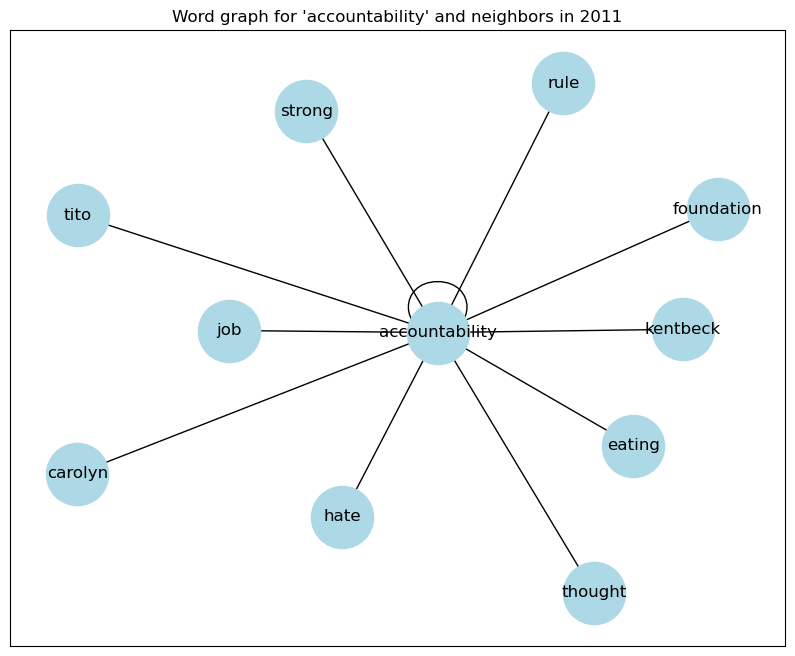

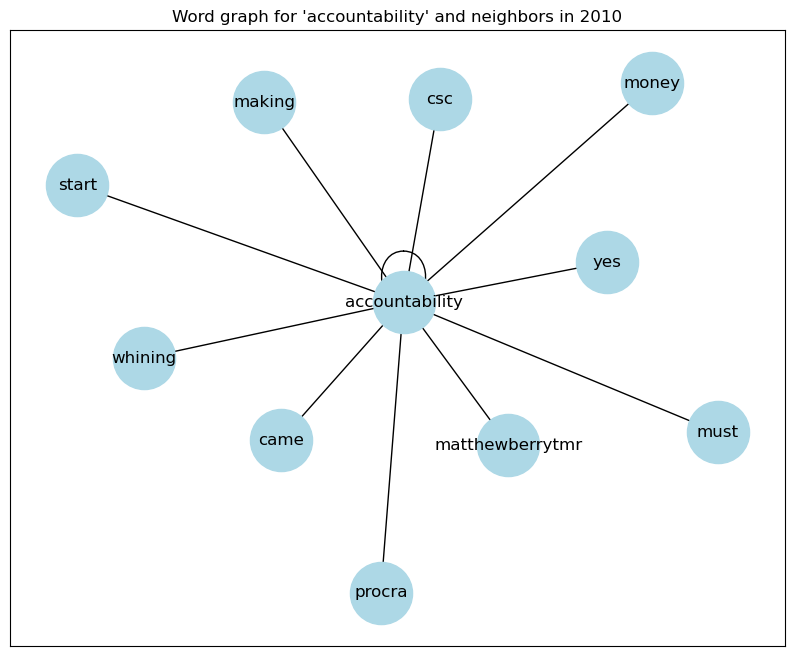

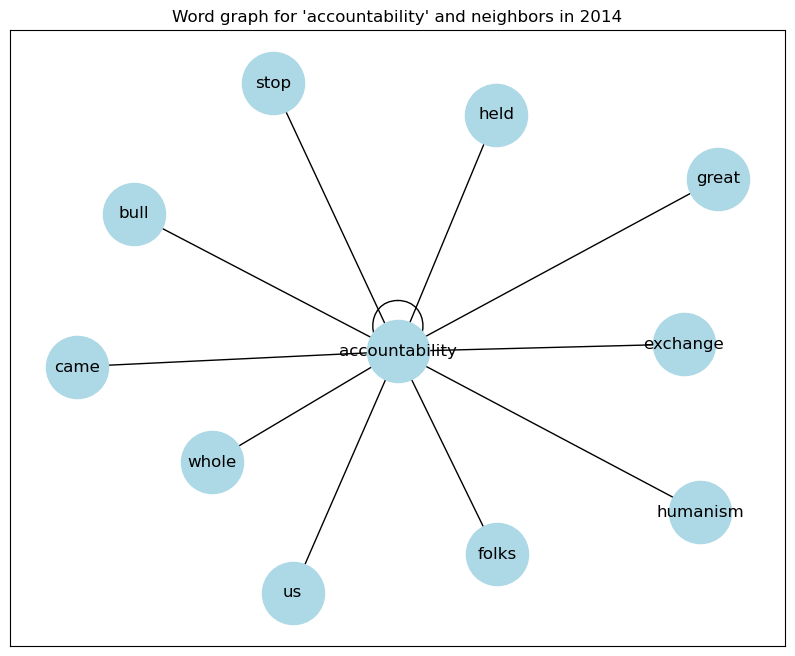

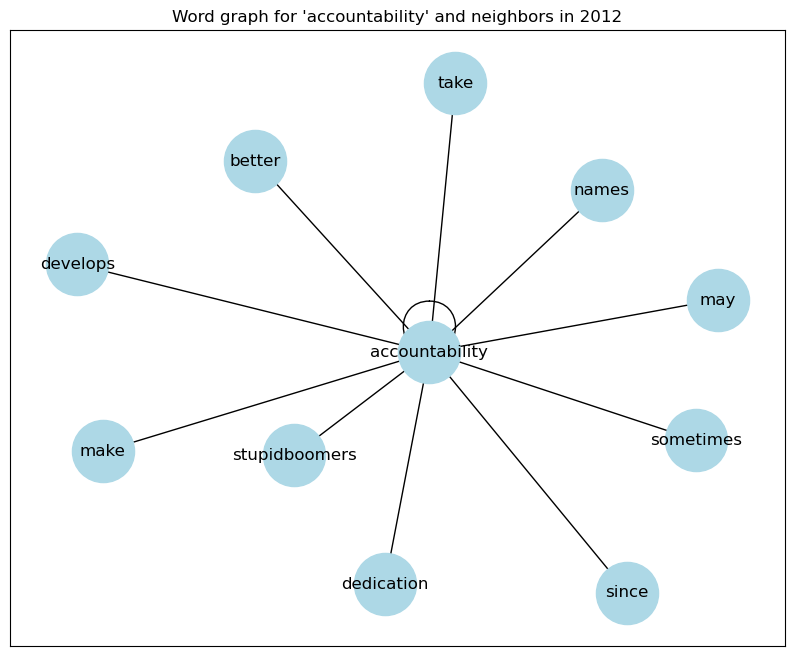

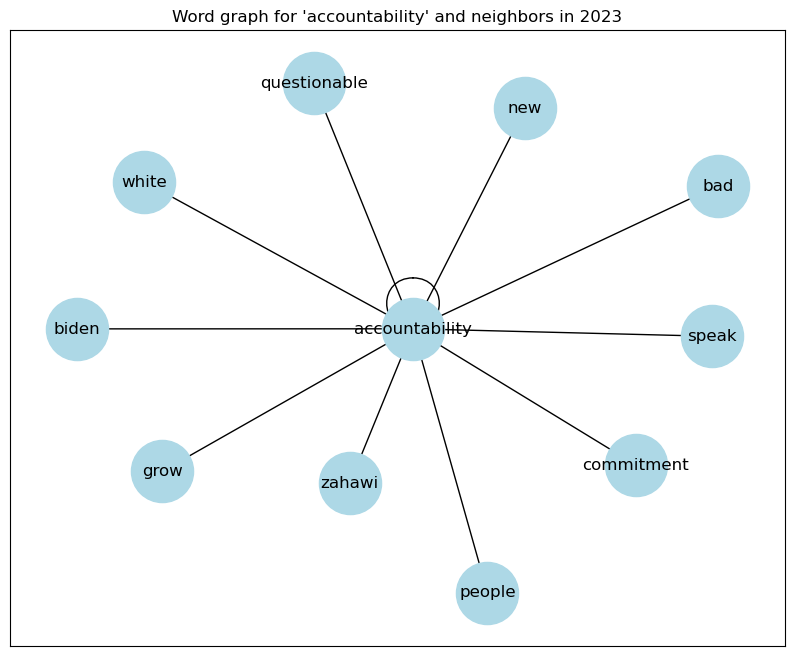

In [16]:
# Visualize graph
for year, sim_scores in similarities.items():
    G = nx.Graph()
    for word, score in sim_scores.items():
        G.add_edge(word, "accountability", weight=score)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 8))
    nx.draw_networkx(G, pos, node_size=2000, node_color='lightblue', with_labels=True)
    plt.title(f"Word graph for 'accountability' and neighbors in {year}")
    plt.show()